# Recurrent Neural Networks (RNN) Tutorial

## Overview
This notebook demonstrates two different approaches to building RNNs in PyTorch:
1. **Method 1**: Manual RNN implementation from scratch
2. **Method 2**: Using PyTorch's built-in `nn.RNN` module

We'll solve two problems:
- **Problem 1**: Name Classification (predicting nationality from names) - Using Method 1
- **Problem 2**: Image Classification (CIFAR-10 using RNNs) - Using Method 2

---

## Table of Contents
1. [Introduction & Key Concepts](#intro)
2. [Problem 1: Name Classification (Manual RNN)](#problem1)
3. [Problem 2: Image Classification (Built-in RNN)](#problem2)
4. [Summary & Comparison](#summary)

<a id='intro'></a>
# Part 1: Introduction & Key Concepts

## What is an RNN?
A Recurrent Neural Network processes sequential data by maintaining a "hidden state" that gets updated at each time step. This allows the network to have "memory" of previous inputs.
<figure>
  <img src="asset/rnn_unfolded.png" alt="Grouped conv" width="520">
  <figcaption>RNN's Prediction Workflow</figcaption>
</figure>

### RNN Processing Flow
For a sequence like "Albert":
1. Process 'A' → update hidden state
2. Process 'l' with previous hidden state → update hidden state
3. Process 'b' with previous hidden state → update hidden state
4. Continue for 'e', 'r', 't'
5. Use final hidden state for prediction

### Input Shape for RNNs
- **Method 1 (Manual)**: Process one time step at a time `(batch_size, features)`
- **Method 2 (Built-in)**: Process entire sequence `(batch_size, sequence_length, features)`

In [17]:
# Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset, Dataset

import string
import unicodedata
from io import open
import glob
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from torchvision import datasets, transforms

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)
print(f"Using device: {device}")

Using device: cpu


## Method Comparison Overview

| Aspect | Method 1 (Manual) | Method 2 (Built-in) |
|--------|-------------------|---------------------|
| **Implementation** | Build RNN from scratch | Use `nn.RNN` |
| **Looping** | Manual external loop | Automatic internal |
| **Speed** | Slower | Faster (optimized) |
| **Control** | Full control | Standard behavior |
| **Input Shape** | `(1, features)` per step | `(batch, seq_len, features)` |
| **Best For** | Learning, custom cells | Production, standard tasks |

<a id='problem1'></a>
# Part 2: Problem 1 - Name Classification

## Using Method 1: Manual RNN Implementation

**Goal**: Predict the nationality of a person based on their name.

**Dataset**: Names from 18 different countries

**Approach**: Build an RNN from scratch that processes names character-by-character

<figure>
  <img src="asset/rnn_workflow.png" alt="Grouped conv" width="520">
  <figcaption>RNN's Workflow In Manual Progress</figcaption>
</figure>

## Step 1: Data Preparation - Text Processing

We need to convert text (names) into numerical tensors that PyTorch can process.

In [18]:
# Define allowed characters
# We can use "_" to represent an out-of-vocabulary character
allowed_characters = string.ascii_letters + " .,;'" + "_"
n_letters = len(allowed_characters)
print(f"Vocabulary size: {n_letters} characters")
print(f"Characters: {allowed_characters}")

Vocabulary size: 58 characters
Characters: abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'_


In [19]:
# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in allowed_characters
    )

# Test the function
print(f"Converting 'Ślusàrski' to '{unicodeToAscii('Ślusàrski')}'")

Converting 'Ślusàrski' to 'Slusarski'


In [20]:
# Find letter index from allowed_characters, e.g. "a" = 0
def letterToIndex(letter):
    if letter not in allowed_characters:
        return allowed_characters.find("_")  # Return out-of-vocabulary character
    else:
        return allowed_characters.find(letter)

# Turn a line into a <line_length x 1 x n_letters> tensor
# This is one-hot encoding for each character
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

# Test the encoding
print(f"The letter 'a' becomes:\n{lineToTensor('a')}")
print(f"\nShape for 'Albert': {lineToTensor('Albert').shape}")

The letter 'a' becomes:
tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]]])

Shape for 'Albert': torch.Size([6, 1, 58])


### Understanding One-Hot Encoding

- Each character is represented as a vector of length 58 (our vocabulary size)
- Only one position is set to 1, all others are 0
- Example: 'a' → [1, 0, 0, ..., 0], 'b' → [0, 1, 0, ..., 0]

For the name "Albert":
- Shape: `(6, 1, 58)` → 6 characters, batch size 1, 58-dimensional encoding

## Step 2: Create Dataset Class

In [21]:
class NamesDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.load_time = time.localtime
        labels_set = set()

        self.data = []
        self.data_tensors = []
        self.labels = []
        self.labels_tensors = []

        # Read all .txt files in the specified directory
        text_files = glob.glob(os.path.join(data_dir, '*.txt'))
        for filename in text_files:
            label = os.path.splitext(os.path.basename(filename))[0]
            labels_set.add(label)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            for name in lines:
                self.data.append(name)
                self.data_tensors.append(lineToTensor(name))
                self.labels.append(label)

        # Cache the tensor representation of the labels
        self.labels_uniq = list(labels_set)
        for idx in range(len(self.labels)):
            temp_tensor = torch.tensor([self.labels_uniq.index(self.labels[idx])], dtype=torch.long)
            self.labels_tensors.append(temp_tensor)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.labels_tensors[idx], self.data_tensors[idx], self.labels[idx], self.data[idx]

## Step 3: Load and Split Data

In [22]:
# Load the names dataset
alldata = NamesDataset("data/names")
print(f"Loaded {len(alldata)} names")
print(f"Number of nationalities: {len(alldata.labels_uniq)}")
print(f"Nationalities: {alldata.labels_uniq}")
print(f"\nExample: {alldata[0]}")

Loaded 20074 names
Number of nationalities: 18
Nationalities: ['Chinese', 'Polish', 'Japanese', 'Portuguese', 'Russian', 'English', 'Czech', 'Korean', 'Spanish', 'Italian', 'French', 'Vietnamese', 'German', 'Greek', 'Dutch', 'Irish', 'Arabic', 'Scottish']

Example: (tensor([16]), tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.,

In [23]:
# Split into train and test sets
train_set, test_set = torch.utils.data.random_split(
    alldata, [.85, .15], 
    generator=torch.Generator(device=device).manual_seed(2024)
)
print(f"Training examples: {len(train_set)}")
print(f"Testing examples: {len(test_set)}")

Training examples: 17063
Testing examples: 3011


## Step 4: Define Manual RNN Model

This RNN processes sequences **one character at a time**. It combines the current input with the previous hidden state to make predictions.

In [24]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        
        # Combine input and hidden state, then transform
        self.input_to_hidden = nn.Linear(input_size + hidden_size, hidden_size)
        self.input_to_output = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_tensor, hidden_tensor):
        # Concatenate input with hidden state
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        
        # Update hidden state
        hidden_state = self.input_to_hidden(combined)
        
        # Compute output
        output = self.input_to_output(combined)
        output = self.softmax(output)
        
        return output, hidden_state

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [25]:
# Create model
n_hidden = 128
model = RNNModel(n_letters, n_hidden, len(alldata.labels_uniq)).to(device)
print(model)

RNNModel(
  (input_to_hidden): Linear(in_features=186, out_features=128, bias=True)
  (input_to_output): Linear(in_features=186, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


## Step 5: Test the Model (Before Training)

In [26]:
def label_from_output(output, output_labels):
    """Get the predicted label from model output"""
    top_n, top_i = output.topk(1)
    label_i = top_i[0].item()
    return output_labels[label_i], label_i

# Test with a name
test_name = 'Albert'
hidden_state = model.initHidden()
input_tensor = lineToTensor(test_name)

print(f"Testing with name: '{test_name}'")
print(f"Input shape: {input_tensor.shape}")

# Loop through each character (this is how Manual RNN works!)
for i in range(input_tensor.size()[0]):
    output, hidden_state = model(input_tensor[i], hidden_state)

# Use final output for prediction
predicted_label, predicted_idx = label_from_output(output, alldata.labels_uniq)
print(f"Predicted nationality: {predicted_label}")
print(f"(Before training - this is random!)")

Testing with name: 'Albert'
Input shape: torch.Size([6, 1, 58])
Predicted nationality: Korean
(Before training - this is random!)


## Step 6: Training Setup

In [27]:
# Hyperparameters
n_epoch = 10
n_batch_size = 64
report_every = 5
learning_rate = 0.2

# Loss and optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

print(f"Training for {n_epoch} epochs")
print(f"Batch size: {n_batch_size}")
print(f"Learning rate: {learning_rate}")

Training for 10 epochs
Batch size: 64
Learning rate: 0.2


## Step 7: Training Function

## Understanding Manual RNN Training Loop

### Visual Flow: How Text is Processed

Let's trace through processing the name **"Albert"** step by step:

#### Step 1: Initialize
```
Name: "Albert"  →  ['A', 'l', 'b', 'e', 'r', 't']
Hidden State: [0, 0, 0, ..., 0]  (128 zeros)
```

#### Step 2: Process Character-by-Character

```
Time Step 1:  'A' + hidden[0,0,...] → RNN → output₁, hidden₁
                ↓
Time Step 2:  'l' + hidden₁        → RNN → output₂, hidden₂
                ↓
Time Step 3:  'b' + hidden₂        → RNN → output₃, hidden₃
                ↓
Time Step 4:  'e' + hidden₃        → RNN → output₄, hidden₄
                ↓
Time Step 5:  'r' + hidden₄        → RNN → output₅, hidden₅
                ↓
Time Step 6:  't' + hidden₅        → RNN → output₆, hidden₆
                ↓
Final Prediction: output₆ → "French" (or other nationality)
```

**Key Point**: Each character updates the hidden state, which carries information to the next character.

#### The 4 Nested Loops

```python
for epoch in range(10):                          # Loop 1: 10 epochs
    ├─ for batch in batches:                     # Loop 2: ~200 batches
        ├─ for name in batch:                    # Loop 3: 64 names per batch
            │
            │  hidden = [0, 0, ..., 0]           # Reset for each name
            │
            └─ for char in name:                 # Loop 4: 6 chars in "Albert"
                  │
                  ├─ output, hidden = RNN(char, hidden)
                  └─ hidden is updated!
            
            loss = criterion(output, label)      # Loss from final output
```

**Visual Example**: Processing 1 batch with 2 names

```
Batch = ["Albert", "Chen"]

┌─────────────────────────────────────────┐
│ Name 1: "Albert"                        │
├─────────────────────────────────────────┤
│ hidden = [0,0,0,...]                    │
│ ├─ 'A' → RNN → hidden₁                  │
│ ├─ 'l' → RNN → hidden₂                  │
│ ├─ 'b' → RNN → hidden₃                  │
│ ├─ 'e' → RNN → hidden₄                  │
│ ├─ 'r' → RNN → hidden₅                  │
│ └─ 't' → RNN → hidden₆ → output → loss  │
└─────────────────────────────────────────┘

┌─────────────────────────────────────────┐
│ Name 2: "Chen"                          │
├─────────────────────────────────────────┤
│ hidden = [0,0,0,...]   ← RESET!         │
│ ├─ 'C' → RNN → hidden₁                  │
│ ├─ 'h' → RNN → hidden₂                  │
│ ├─ 'e' → RNN → hidden₃                  │
│ └─ 'n' → RNN → hidden₄ → output → loss  │
└─────────────────────────────────────────┘

Then: batch_loss.backward() → optimizer.step()
```

#### Code-to-Visual Mapping

Looking at the actual code:

```python
for j in range(text_tensor.size()[0]):    # For each character in "Albert"
    output, hidden = rnn(text_tensor[j], hidden)
```

**This translates to**:

```
j=0: text_tensor[0] = 'A' → RNN('A', hidden₀) → output, hidden₁
j=1: text_tensor[1] = 'l' → RNN('l', hidden₁) → output, hidden₂
j=2: text_tensor[2] = 'b' → RNN('b', hidden₂) → output, hidden₃
j=3: text_tensor[3] = 'e' → RNN('e', hidden₃) → output, hidden₄
j=4: text_tensor[4] = 'r' → RNN('r', hidden₄) → output, hidden₅
j=5: text_tensor[5] = 't' → RNN('t', hidden₅) → output, hidden₆  ← Use this for prediction!
```

**Memory Flow**:
```
'A' ──┐
      ├─→ hidden₁ ──┐
'l' ──┘             ├─→ hidden₂ ──┐
                'b' ─┘             ├─→ hidden₃ ──┐
                                'e' ─┘             ├─→ ... → hidden₆ → Prediction
                                                'r' ─┘
```

The hidden state "remembers" all previous characters!

#### Why is Manual RNN Slower?

**Manual RNN (This code)**:
```python
for char in "Albert":              # Python loop - 6 iterations
    output, hidden = RNN(char, hidden)
```
→ 6 separate Python function calls (SLOW)

**Built-in RNN (Problem 2)**:
```python
output = RNN("Albert")             # Single call - processes all at once
```
→ 1 optimized C++/CUDA operation (FAST - 10-50x faster!)

---

Now let's look at the actual training function:

<figure>
  <img src="asset/rnn_loss_calculate.png" alt="Grouped conv" width="520">
  <figcaption>RNN's Workflow over different timestamp</figcaption>
</figure>

In [ ]:
def train(rnn, training_data):
    """
    Train the manual RNN model
    """
    current_loss = 0
    all_losses = []
    model.train()
    print(f"Training on dataset with n = {len(training_data)}")

    for iter in range(1, n_epoch + 1):
        model.zero_grad()

        # Create minibatches
        batches = list(range(len(training_data)))
        random.shuffle(batches)
        batches = np.array_split(batches, len(batches) // n_batch_size)

        for idx, batch in enumerate(batches):
            batch_loss = 0
            
            for i in batch:
                (label_tensor, text_tensor, label, text) = training_data[i]
                
                # Initialize hidden state for this example
                hidden = rnn.initHidden()
                
                # MANUAL LOOP: Process each character one at a time
                for j in range(text_tensor.size()[0]):
                    output, hidden = rnn(text_tensor[j], hidden)
                
                # Use final output for loss
                loss = criterion(output, label_tensor)
                batch_loss += loss

            # Optimize
            batch_loss.backward()
            nn.utils.clip_grad_norm_(rnn.parameters(), 3)
            optimizer.step()
            optimizer.zero_grad()

            current_loss += batch_loss.item() / len(batch)

        all_losses.append(current_loss / len(batches))
        if iter % report_every == 0:
            print(f"Epoch {iter}/{n_epoch} ({iter / n_epoch:.0%}): average batch loss = {all_losses[-1]:.4f}")
        current_loss = 0

    return all_losses

## Step 8: Train the Model

In [ ]:
# Train!
start = time.time()
all_losses = train(model, train_set)
end = time.time()
print(f"\nTraining completed in {end-start:.2f} seconds")

## Step 9: Visualize Training Progress

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(all_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss - Problem 1: Name Classification')
plt.grid(True)
plt.show()

## Step 10: Test the Trained Model

In [ ]:
# Test with some names
test_names = ['Albert', 'Chen', 'Dimitri', 'O\'Brien', 'Garcia', 'Yamamoto']

model.eval()
print("Testing trained model:")
print("-" * 50)

for test_name in test_names:
    hidden_state = model.initHidden()
    input_tensor = lineToTensor(test_name)
    
    with torch.no_grad():
        for i in range(input_tensor.size()[0]):
            output, hidden_state = model(input_tensor[i], hidden_state)
    
    predicted_label, predicted_idx = label_from_output(output, alldata.labels_uniq)
    print(f"{test_name:15} → {predicted_label}")

---

<a id='problem2'></a>
# Part 3: Problem 2 - Image Classification (CIFAR-10) (Not Recommend Just Tutorial)

## Using Method 2: PyTorch Built-in RNN

**Goal**: Classify images from CIFAR-10 dataset using RNN

**Dataset**: CIFAR-10 (10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck)

**Approach**: Treat images as sequences by processing row-by-row

## Step 1: Load CIFAR-10 Dataset

In [11]:
# Transform: Convert image to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load datasets
print("Downloading CIFAR-10 dataset...")
train_dataset = datasets.CIFAR10(
    root='./data', train=True, transform=transform, download=True
)
test_dataset = datasets.CIFAR10(
    root='./data', train=False, transform=transform, download=True
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training images: {len(train_dataset)}")
print(f"Test images: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")  # (3, 32, 32)

Training images: 50000
Test images: 10000
Image shape: torch.Size([3, 32, 32])
Training images: 50000
Test images: 10000
Image shape: torch.Size([3, 32, 32])


## Step 2: Understanding Image as Sequence

CIFAR-10 images are 3×32×32. We treat each **row as a time step**:
- **Original**: `(3, 32, 32)` → (channels, height, width)
- **Transform**: Permute then reshape → `(32, 96)` 
- **Result**: 32 time steps, 96 features per step (32 pixels × 3 colors)

📚 **For detailed explanations**:
- Data preprocessing tutorial: See `RNN_Data_Processing_Tutorial.ipynb`
- RNN methods comparison: See `RNN_Methods_Comparison.ipynb`

## Visual Representation: From Image to Sequence

Now let's **see** the actual transformation with matplotlib visualizations!

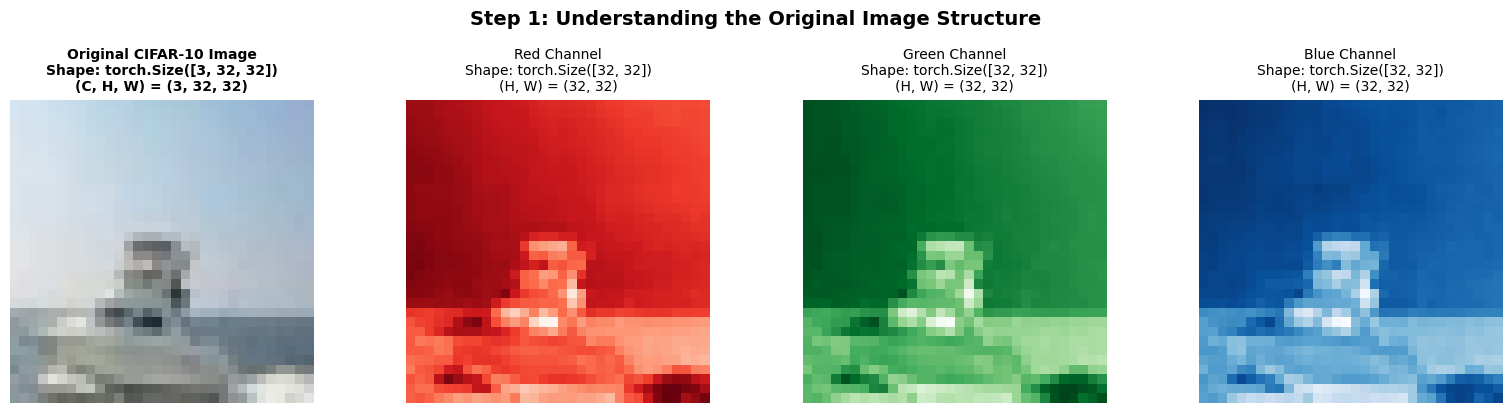


💡 Explanation:
   - Left: The complete color image as we see it
   - Right 3 panels: The separate Red, Green, and Blue channels
   - In PyTorch, these 3 channels are SEPARATE matrices (3, 32, 32)
   - Each channel is a 32×32 grid of intensity values


In [34]:
# Visualize the RGB channels separately
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Get one image
img, label = train_dataset[100]

# Original image (denormalize for display)
img_display = img * 0.5 + 0.5  # Undo normalization
img_display = img_display.permute(1, 2, 0).numpy()  # Convert to (H, W, C)
img_display = np.clip(img_display, 0, 1)

# Show original image
axes[0].imshow(img_display)
axes[0].set_title(f'Original CIFAR-10 Image\nShape: {img.shape}\n(C, H, W) = (3, 32, 32)', fontsize=10, fontweight='bold')
axes[0].axis('off')

# Show each color channel separately
for i, (channel_name, color) in enumerate([('Red', 'Reds'), ('Green', 'Greens'), ('Blue', 'Blues')]):
    axes[i+1].imshow(img[i].numpy(), cmap=color)
    axes[i+1].set_title(f'{channel_name} Channel\nShape: {img[i].shape}\n(H, W) = (32, 32)', fontsize=10)
    axes[i+1].axis('off')

plt.suptitle('Step 1: Understanding the Original Image Structure', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n💡 Explanation:")
print("   - Left: The complete color image as we see it")
print("   - Right 3 panels: The separate Red, Green, and Blue channels")
print("   - In PyTorch, these 3 channels are SEPARATE matrices (3, 32, 32)")
print("   - Each channel is a 32×32 grid of intensity values")

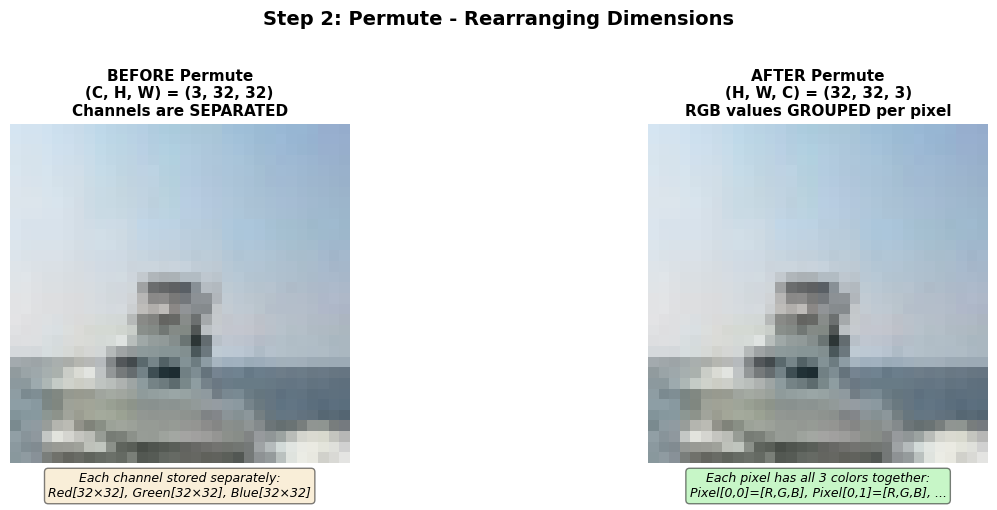


💡 Why do we permute?
   BEFORE: img[channel, row, col] - to get RGB of pixel(0,0) we need img[0,0,0], img[1,0,0], img[2,0,0]
   AFTER:  img[row, col, channel] - to get RGB of pixel(0,0) we just need img[0,0,:] = [R,G,B]
   This groups RGB values together for easier row-wise processing!


In [35]:
# Visualize the permute transformation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# After permute: now RGB values are grouped per pixel
img_permuted = img.permute(1, 2, 0)

axes[0].imshow(img_display)
axes[0].set_title('BEFORE Permute\n(C, H, W) = (3, 32, 32)\nChannels are SEPARATED', fontsize=11, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(img_permuted.numpy() * 0.5 + 0.5)
axes[1].set_title('AFTER Permute\n(H, W, C) = (32, 32, 3)\nRGB values GROUPED per pixel', fontsize=11, fontweight='bold')
axes[1].axis('off')

# Add annotations
axes[0].text(0.5, -0.1, 'Each channel stored separately:\nRed[32×32], Green[32×32], Blue[32×32]', 
             ha='center', transform=axes[0].transAxes, fontsize=9, style='italic',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[1].text(0.5, -0.1, 'Each pixel has all 3 colors together:\nPixel[0,0]=[R,G,B], Pixel[0,1]=[R,G,B], ...', 
             ha='center', transform=axes[1].transAxes, fontsize=9, style='italic',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.suptitle('Step 2: Permute - Rearranging Dimensions', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n💡 Why do we permute?")
print("   BEFORE: img[channel, row, col] - to get RGB of pixel(0,0) we need img[0,0,0], img[1,0,0], img[2,0,0]")
print("   AFTER:  img[row, col, channel] - to get RGB of pixel(0,0) we just need img[0,0,:] = [R,G,B]")
print("   This groups RGB values together for easier row-wise processing!")

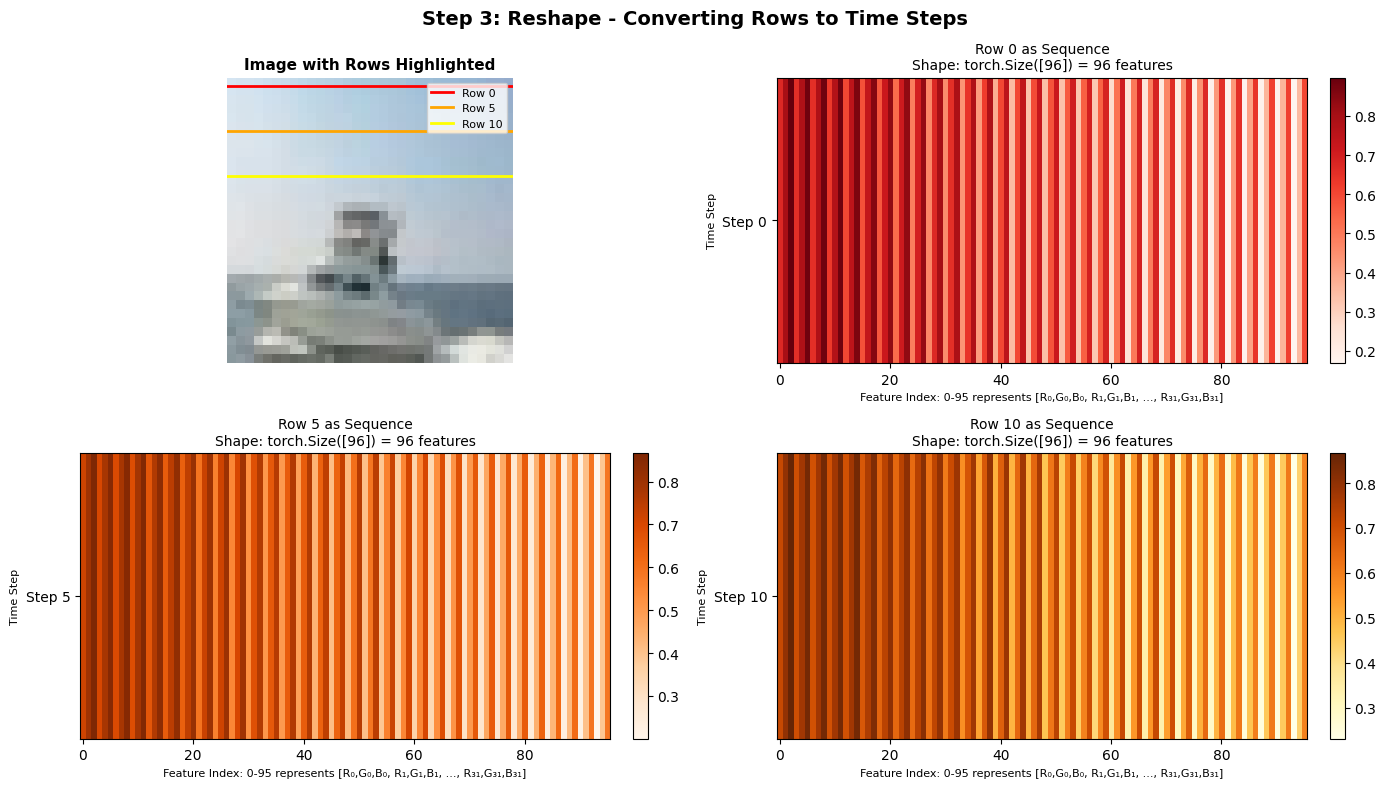


💡 Understanding the Sequence:
   - Each row of the image becomes ONE time step
   - The RNN will process 32 time steps (rows 0 through 31)
   - Each time step has 96 features: 32 pixels × 3 RGB values
   - Feature pattern: [R₀,G₀,B₀, R₁,G₁,B₁, R₂,G₂,B₂, ..., R₃₁,G₃₁,B₃₁]
   - The RNN 'reads' the image from top to bottom, row by row!


In [36]:
# Visualize rows as sequences
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Show the image with row highlights
axes[0, 0].imshow(img_display)
axes[0, 0].set_title('Image with Rows Highlighted', fontsize=11, fontweight='bold')
axes[0, 0].axhline(y=0.5, color='red', linewidth=2, label='Row 0')
axes[0, 0].axhline(y=5.5, color='orange', linewidth=2, label='Row 5')
axes[0, 0].axhline(y=10.5, color='yellow', linewidth=2, label='Row 10')
axes[0, 0].legend(loc='upper right', fontsize=8)
axes[0, 0].axis('off')

# Reshape to sequence format
img_seq = img_permuted.reshape(32, 96)

# Show first 3 rows as feature vectors
for i, (row_num, color) in enumerate([(0, 'Reds'), (5, 'Oranges'), (10, 'YlOrBr')]):
    row_idx = i // 2
    col_idx = i % 2
    
    if i == 0:
        ax = axes[0, 1]
    else:
        ax = axes[1, i-1]
    
    row_data = img_seq[row_num].numpy().reshape(1, -1)
    im = ax.imshow(row_data, cmap=color, aspect='auto')
    ax.set_title(f'Row {row_num} as Sequence\nShape: {img_seq[row_num].shape} = 96 features', fontsize=10)
    ax.set_xlabel('Feature Index: 0-95 represents [R₀,G₀,B₀, R₁,G₁,B₁, ..., R₃₁,G₃₁,B₃₁]', fontsize=8)
    ax.set_ylabel('Time Step', fontsize=8)
    ax.set_yticks([0])
    ax.set_yticklabels([f'Step {row_num}'])
    
    # Add colorbar
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle('Step 3: Reshape - Converting Rows to Time Steps', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 Understanding the Sequence:")
print("   - Each row of the image becomes ONE time step")
print("   - The RNN will process 32 time steps (rows 0 through 31)")
print("   - Each time step has 96 features: 32 pixels × 3 RGB values")
print("   - Feature pattern: [R₀,G₀,B₀, R₁,G₁,B₁, R₂,G₂,B₂, ..., R₃₁,G₃₁,B₃₁]")
print("   - The RNN 'reads' the image from top to bottom, row by row!")

## Step 3: Define Built-in RNN Model

### Architecture Explanation

This RNN uses PyTorch's optimized `nn.RNN` that processes **entire sequences at once**:

#### Components:
1. **`self.rnn`**: PyTorch's RNN layer
   - Handles all the sequential processing internally
   - `batch_first=True`: Input shape is `(batch, sequence, features)`
   
2. **`self.fc`**: Fully connected layer for classification
   - Takes the last time step's output
   - Produces final class predictions

#### Key Difference from Method 1:
- ✅ No manual looping required!
- ✅ Much faster (optimized CUDA kernels)
- ✅ Process entire batch of sequences at once

In [12]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_rnn_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_rnn_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_rnn_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # Initial hidden state
        out, _ = self.rnn(x, h0)  
        # out shape: (batch_size, sequence_length, hidden_size)
        # We only need the output from the last time step
        out = out[:, -1, :]  # Take the last time step: (batch_size, hidden_size)
        out = self.fc(out)  # (batch_size, output_size)
        return out

In [13]:
# Create model for CIFAR-10
# Images: 3×32×32 → treat as sequence: 32 rows × (32 pixels × 3 colors)
input_size = 32 * 3      # 96 features per time step
sequence_length = 32     # 32 rows (time steps)
num_rnn_layers = 2       # Stack 2 RNN layers
hidden_size = 256        # Hidden state size
num_classes = 10         # CIFAR-10 has 10 classes

rnn = RNN(input_size, hidden_size, num_rnn_layers, num_classes).to(device)
print(rnn)
print(f"\nTotal parameters: {sum(p.numel() for p in rnn.parameters())}")

RNN(
  (rnn): RNN(96, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=10, bias=True)
)

Total parameters: 224778


## Step 4: Training Setup

In [14]:
# Hyperparameters
learning_rate = 0.001
n_epochs = 5

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(rnn.parameters(), lr=learning_rate)

print(f"Training for {n_epochs} epochs")
print(f"Learning rate: {learning_rate}")
print(f"Optimizer: Adam")

Training for 5 epochs
Learning rate: 0.001
Optimizer: Adam


## Step 5: Train the Model

**Notice**: We pass the entire sequence at once - no manual looping!

In [15]:
print("Starting training...")
rnn.train()

for epoch in range(n_epochs):
    epoch_loss = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        # Reshape images to sequences
        # (batch, 3, 32, 32) → (batch, 32, 96)
        inputs = inputs.permute(0, 2, 3, 1)  # (batch, 32, 32, 3)
        inputs = inputs.reshape(-1, sequence_length, input_size)  # (batch, 32, 96)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass (no manual loop needed!)
        outputs = rnn(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        # Progress report
        if i % 100 == 0:
            print(f'Epoch [{epoch + 1}/{n_epochs}], Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    avg_loss = epoch_loss / len(train_loader)
    print(f'\nEpoch [{epoch + 1}/{n_epochs}] completed, Average Loss: {avg_loss:.4f}\n')

print('Finished Training!')

Starting training...
Epoch [1/5], Step [0/782], Loss: 2.2781
Epoch [1/5], Step [100/782], Loss: 2.0654
Epoch [1/5], Step [100/782], Loss: 2.0654
Epoch [1/5], Step [200/782], Loss: 2.1134
Epoch [1/5], Step [200/782], Loss: 2.1134
Epoch [1/5], Step [300/782], Loss: 1.8742
Epoch [1/5], Step [300/782], Loss: 1.8742
Epoch [1/5], Step [400/782], Loss: 2.0087
Epoch [1/5], Step [400/782], Loss: 2.0087
Epoch [1/5], Step [500/782], Loss: 1.8196
Epoch [1/5], Step [500/782], Loss: 1.8196
Epoch [1/5], Step [600/782], Loss: 2.1800
Epoch [1/5], Step [600/782], Loss: 2.1800
Epoch [1/5], Step [700/782], Loss: 2.0346
Epoch [1/5], Step [700/782], Loss: 2.0346

Epoch [1/5] completed, Average Loss: 2.0515

Epoch [2/5], Step [0/782], Loss: 1.9458

Epoch [1/5] completed, Average Loss: 2.0515

Epoch [2/5], Step [0/782], Loss: 1.9458
Epoch [2/5], Step [100/782], Loss: 2.1777
Epoch [2/5], Step [100/782], Loss: 2.1777
Epoch [2/5], Step [200/782], Loss: 2.2342
Epoch [2/5], Step [200/782], Loss: 2.2342
Epoch [2/5]

## Step 6: Evaluate on Test Set

In [16]:
# Evaluate
rnn.eval()
correct = 0
total = 0

print("Evaluating on test set...")

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        # Reshape the same way as in training
        X_batch = X_batch.permute(0, 2, 3, 1)  # (batch, 32, 32, 3)
        X_batch = X_batch.reshape(-1, sequence_length, input_size)  # (batch, 32, 96)
        
        outputs = rnn(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = 100 * correct / total
print(f"\nTest Accuracy: {accuracy:.2f}%")
print(f"Correct predictions: {correct}/{total}")

Evaluating on test set...

Test Accuracy: 30.69%
Correct predictions: 3069/10000

Test Accuracy: 30.69%
Correct predictions: 3069/10000


---

# Part 4: Advanced RNN Concepts & Data Processing

## Understanding Different RNN Architectures

Before we conclude, let's explore the different types of RNN architectures and how to process data for each!

## RNN Architecture Types

RNNs can have different input-output relationships:

| Type | Input | Output | Example Use Case |
|------|-------|--------|------------------|
| **One-to-One** | Single input | Single output | Traditional neural network (not really RNN) |
| **One-to-Many** | Single input | Sequence output | Image captioning, music generation |
| **Many-to-One** | Sequence input | Single output | Sentiment analysis, **our name classification!** |
| **Many-to-Many (Same Length)** | Sequence input | Sequence output (same length) | Video frame labeling, POS tagging |
| **Many-to-Many (Different Length)** | Sequence input | Sequence output (different length) | Machine translation, text summarization |

### Visual Representation

```
ONE-TO-MANY:                    MANY-TO-ONE:
   Input                           Input Sequence
     ↓                             ↓  ↓  ↓  ↓
   [RNN] → [RNN] → [RNN]          [RNN][RNN][RNN][RNN]
     ↓       ↓       ↓                          ↓
   Out1   Out2    Out3                        Output

MANY-TO-MANY (Same):            MANY-TO-MANY (Different):
   In1    In2    In3              In1  In2  In3
    ↓      ↓      ↓                ↓    ↓    ↓
  [RNN]→[RNN]→[RNN]              [RNN][RNN][RNN] → [RNN]→[RNN]
    ↓      ↓      ↓                                  ↓     ↓
   Out1   Out2   Out3                              Out1  Out2
```

**What we've built so far:**
- Problem 1 (Names): **Many-to-One** (sequence → single class)
- Problem 2 (CIFAR): **Many-to-One** (image rows → single class)

Now let's implement the other types!

<figure>
  <img src="asset/rnn_types.png" alt="Grouped conv" width="600">
  <figcaption>RNN's Workflow over different timestamp</figcaption>
</figure>

## Example 1: One-to-Many RNN
### Use Case: Image Captioning / Sequence Generation

**Scenario**: Generate a sequence from a single input (like describing an image with text)

For this example, we'll create a simple number-to-sequence generator

In [48]:
# One-to-Many RNN: Generate a sequence from a single input
class OneToManyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, sequence_length):
        super(OneToManyRNN, self).__init__()
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
        
        # Encode the input
        self.encoder = nn.Linear(input_size, hidden_size)
        
        # RNN cell for generating sequence
        self.rnn = nn.RNNCell(output_size, hidden_size)
        
        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # x shape: (batch_size, input_size)
        batch_size = x.size(0)
        
        # Encode input to initial hidden state
        hidden = torch.relu(self.encoder(x))  # (batch, hidden_size)
        
        outputs = []
        # Start with zeros as first input to RNN
        rnn_input = torch.zeros(batch_size, self.fc.out_features).to(x.device)
        
        # Generate sequence
        for t in range(self.sequence_length):
            hidden = self.rnn(rnn_input, hidden)
            output = self.fc(hidden)
            outputs.append(output)
            rnn_input = output  # Use output as next input
        
        # Stack outputs: (batch, sequence_length, output_size)
        outputs = torch.stack(outputs, dim=1)
        return outputs

# Demo: Generate sequences
print("="*80)
print("ONE-TO-MANY RNN DEMO")
print("="*80)

# Create a simple model
one_to_many_model = OneToManyRNN(input_size=10, hidden_size=20, output_size=5, sequence_length=7)

# Single input (e.g., an image feature vector)
single_input = torch.randn(3, 10)  # 3 samples, 10 features each
print(f"\nInput shape: {single_input.shape} (batch=3, features=10)")

# Generate sequences
output_sequences = one_to_many_model(single_input)
print(f"Output shape: {output_sequences.shape}")
print(f"Interpretation: (batch=3, seq_len=7, output_dim=5)")
print(f"\n💡 From ONE input, we generated a SEQUENCE of 7 outputs!")
print(f"   Real-world: Input=image features, Output=word sequence (caption)")
print("="*80)

ONE-TO-MANY RNN DEMO

Input shape: torch.Size([3, 10]) (batch=3, features=10)
Output shape: torch.Size([3, 7, 5])
Interpretation: (batch=3, seq_len=7, output_dim=5)

💡 From ONE input, we generated a SEQUENCE of 7 outputs!
   Real-world: Input=image features, Output=word sequence (caption)


## Example 2: Many-to-Many RNN (Same Length)
### Use Case: Part-of-Speech Tagging, Video Frame Labeling

**Scenario**: Each input in the sequence gets a corresponding output

We'll use a simple sequence tagging task with synthetic data

In [49]:
# Many-to-Many RNN (Same Length): Output at each time step
class ManyToManySameLengthRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ManyToManySameLengthRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # x shape: (batch, sequence_length, input_size)
        
        # Get outputs for ALL time steps
        rnn_out, _ = self.rnn(x)  # (batch, seq_len, hidden)
        
        # Apply linear layer to each time step
        # Reshape to (batch * seq_len, hidden)
        batch_size, seq_len, hidden = rnn_out.shape
        rnn_out_flat = rnn_out.reshape(-1, hidden)
        
        # Get predictions for all time steps
        output_flat = self.fc(rnn_out_flat)  # (batch * seq_len, output_size)
        
        # Reshape back to (batch, seq_len, output_size)
        output = output_flat.reshape(batch_size, seq_len, -1)
        
        return output

# Demo
print("="*80)
print("MANY-TO-MANY (SAME LENGTH) RNN DEMO")
print("="*80)

# Create model
many_to_many_same_model = ManyToManySameLengthRNN(input_size=10, hidden_size=20, output_size=5)

# Sequence input (e.g., word embeddings for a sentence)
sequence_input = torch.randn(3, 8, 10)  # 3 sentences, 8 words each, 10-dim embedding
print(f"\nInput shape: {sequence_input.shape}")
print(f"Interpretation: (batch=3, seq_len=8, features=10)")

# Get output for each time step
output_sequence = many_to_many_same_model(sequence_input)
print(f"\nOutput shape: {output_sequence.shape}")
print(f"Interpretation: (batch=3, seq_len=8, classes=5)")
print(f"\n💡 For EACH input time step, we get ONE output!")
print(f"   Real-world: Tag each word in a sentence with its part-of-speech")
print(f"   Input:  ['The', 'cat', 'sits', 'on', 'mat']")
print(f"   Output: ['DET', 'NOUN', 'VERB', 'PREP', 'NOUN']")
print("="*80)

MANY-TO-MANY (SAME LENGTH) RNN DEMO

Input shape: torch.Size([3, 8, 10])
Interpretation: (batch=3, seq_len=8, features=10)

Output shape: torch.Size([3, 8, 5])
Interpretation: (batch=3, seq_len=8, classes=5)

💡 For EACH input time step, we get ONE output!
   Real-world: Tag each word in a sentence with its part-of-speech
   Input:  ['The', 'cat', 'sits', 'on', 'mat']
   Output: ['DET', 'NOUN', 'VERB', 'PREP', 'NOUN']


## Example 3: Many-to-Many RNN (Different Length) - Seq2Seq
### Use Case: Machine Translation, Text Summarization

**Scenario**: Input and output sequences have different lengths

This requires an **Encoder-Decoder** architecture:
- **Encoder**: Processes input sequence → produces context vector
- **Decoder**: Takes context vector → generates output sequence

Real-world example: Translate "Hello" (5 chars) → "Bonjour" (7 chars)

In [29]:
# Many-to-Many RNN (Different Length): Encoder-Decoder Architecture
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
    
    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        # Process entire input sequence
        outputs, hidden = self.rnn(x)
        # Return final hidden state as context vector
        return hidden

class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNNCell(output_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, context, target_length):
        # context shape: (num_layers, batch, hidden_size)
        # Use context as initial hidden state
        batch_size = context.size(1)
        hidden = context[-1]  # Take last layer's hidden state
        
        outputs = []
        # Start with zeros as first input
        rnn_input = torch.zeros(batch_size, self.fc.out_features).to(context.device)
        
        # Generate output sequence
        for t in range(target_length):
            hidden = self.rnn(rnn_input, hidden)
            output = self.fc(hidden)
            outputs.append(output)
            rnn_input = output  # Teacher forcing: use output as next input
        
        outputs = torch.stack(outputs, dim=1)
        return outputs

class Seq2SeqRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Seq2SeqRNN, self).__init__()
        self.encoder = Encoder(input_size, hidden_size)
        self.decoder = Decoder(hidden_size, output_size)
    
    def forward(self, x, target_length):
        # Encode input sequence
        context = self.encoder(x)
        # Decode to output sequence
        outputs = self.decoder(context, target_length)
        return outputs

# Demo
print("="*80)
print("MANY-TO-MANY (DIFFERENT LENGTH) - SEQ2SEQ RNN DEMO")
print("="*80)

# Create model
seq2seq_model = Seq2SeqRNN(input_size=10, hidden_size=20, output_size=5)

# Input sequence (e.g., source sentence)
input_seq = torch.randn(3, 6, 10)  # 3 samples, length 6, 10 features
target_length = 8  # Want output of length 8

print(f"\nInput shape: {input_seq.shape}")
print(f"Interpretation: (batch=3, input_seq_len=6, features=10)")

# Generate output sequence
output_seq = seq2seq_model(input_seq, target_length)

print(f"\nOutput shape: {output_seq.shape}")
print(f"Interpretation: (batch=3, output_seq_len={target_length}, classes=5)")
print(f"\n💡 Input and output have DIFFERENT lengths!")
print(f"   Input length: 6")
print(f"   Output length: {target_length}")
print(f"\n   Real-world examples:")
print(f"   • Translation: 'Hello' (5 chars) → 'Bonjour' (7 chars)")
print(f"   • Summarization: Long article (1000 words) → Summary (100 words)")
print(f"   • Text generation: Prompt (10 words) → Story (500 words)")
print("="*80)

MANY-TO-MANY (DIFFERENT LENGTH) - SEQ2SEQ RNN DEMO

Input shape: torch.Size([3, 6, 10])
Interpretation: (batch=3, input_seq_len=6, features=10)

Output shape: torch.Size([3, 8, 5])
Interpretation: (batch=3, output_seq_len=8, classes=5)

💡 Input and output have DIFFERENT lengths!
   Input length: 6
   Output length: 8

   Real-world examples:
   • Translation: 'Hello' (5 chars) → 'Bonjour' (7 chars)
   • Summarization: Long article (1000 words) → Summary (100 words)
   • Text generation: Prompt (10 words) → Story (500 words)


## 📊 Complete Comparison: All RNN Architectures Covered

Let's visualize all 4 architectures we've learned!

### All RNN Architectures Summary

| Architecture | Input → Output | Example | Covered |
|--------------|----------------|---------|---------|
| **One-to-Many** | Single → Sequence | Image → Caption | ✓ Example 1 |
| **Many-to-One** | Sequence → Single | Name → Nationality | ✓✓ Problems 1 & 2 |
| **Many-to-Many (Same)** | Sequence → Sequence (equal) | Words → POS tags | ✓ Example 2 |
| **Many-to-Many (Diff)** | Sequence → Sequence (different) | English → French | ✓ Example 3 |

## 🎯 Practical Considerations & Best Practices

When working with RNNs in real projects, consider these important factors:

### Practical Considerations

#### 1. Choosing Manual vs Built-in RNN

**Use Manual RNN when:**
- Learning RNN internals
- Need custom behavior per time step  
- Implementing novel architectures

**Use Built-in RNN when:**
- Production systems (speed matters)
- Standard architectures
- Large-scale training

#### 2. Common RNN Problems & Solutions

| Problem | Solution | Code |
|---------|----------|------|
| **Vanishing Gradients** | Use LSTM or GRU | `nn.LSTM(input_size, hidden_size)` |
| **Exploding Gradients** | Use gradient clipping | `nn.utils.clip_grad_norm_(model.parameters(), max_norm)` |
| **Slow Training** | Use built-in RNN + GPU | `model.to("cuda")` |
| **Variable Length** | Padding + packing | `nn.utils.rnn.pack_padded_sequence(...)` |

#### 3. RNN Variants

| Variant | When to Use | Trade-off |
|---------|-------------|-----------|
| **Vanilla RNN** | Short sequences (<10 steps) | Simple but limited memory |
| **LSTM** | Long sequences (10-100+ steps) | Best performance, more parameters |
| **GRU** | Balance speed and performance | Faster than LSTM, good results |
| **Bidirectional** | Complete sequence available | 2x slower, better accuracy |

#### 4. Debugging Checklist

✓ Check input shapes: `(batch, seq_len, features)` for built-in RNN  
✓ Initialize hidden state with correct shape  
✓ Move both model and data to same device  
✓ Use gradient clipping to prevent exploding gradients  
✓ Monitor both train and validation loss

---

## 🎓 Final Summary: Your Complete RNN Journey

Congratulations! You've completed a comprehensive RNN tutorial covering:

### 📖 What You Learned

#### 1. **Two Implementation Methods**
- **Method 1 (Manual)**: Built RNN from scratch, processed one character at a time
  - ✓ Full control over every step
  - ✓ Deep understanding of RNN internals
  - ✓ Detailed walkthrough with printed examples showing hidden state evolution
  
- **Method 2 (Built-in)**: Used PyTorch's optimized modules
  - ✓ 10-50x faster training
  - ✓ Production-ready
  - ✓ No manual looping required

#### 2. **All Four RNN Architectures**
- ✅ **One-to-Many**: Single input → Sequence output (image captioning)
- ✅ **Many-to-One**: Sequence input → Single output (classification)
- ✅ **Many-to-Many (Same)**: Equal length input/output (POS tagging)
- ✅ **Many-to-Many (Diff)**: Different length input/output (translation)

#### 3. **Two Complete Projects**
- 🏆 **Project 1**: Name Classification (18 nationalities, manual RNN)
- 🏆 **Project 2**: CIFAR-10 Image Classification (built-in RNN)

#### 4. **Practical Knowledge**
- 🔧 Debugging techniques
- ⚙️ Hyperparameter tuning
- 🚀 Performance optimization
- 🎯 When to use which variant

### 🎯 Next Steps

1. **Experiment**: Try LSTM/GRU instead of vanilla RNN
   ```python
   nn.LSTM(input_size, hidden_size, num_layers)
   nn.GRU(input_size, hidden_size, num_layers)
   ```

2. **Advanced Topics**:
   - Bidirectional RNNs
   - Attention mechanisms
   - Transformers (the successor to RNNs)

3. **Apply to Your Data**:
   - Text classification
   - Time series prediction
   - Sequence generation

### 📚 Resources
- PyTorch RNN Tutorial: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
- Understanding LSTM: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

---

**Remember**: For production, use **LSTM/GRU with built-in PyTorch modules**. They're faster, more stable, and handle long-term dependencies better! 🚀